Starting WGAN-GP training for 30 epochs...


Epoch 30/30: 100%|██████████| 938/938 [02:09<00:00,  7.22it/s, Loss_C=-2.2872, Loss_G=33.2237]


Training Finished!


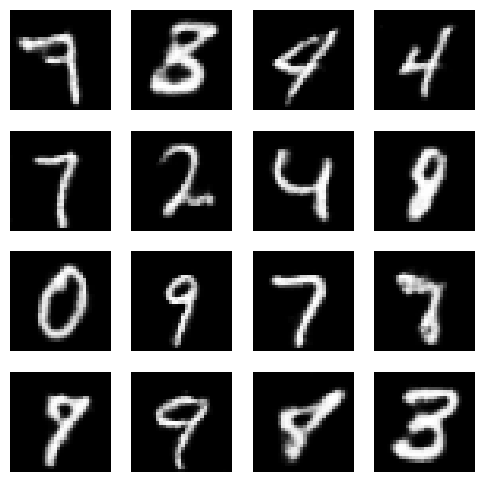

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 32
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 30
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10


class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            # Input: N x 1 x 32 x 32
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # 16x16
            nn.Conv2d(features_d, features_d * 2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(features_d * 2, affine=True),
            nn.LeakyReLU(0.2),
            # 8x8
            nn.Conv2d(features_d * 2, features_d * 4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(features_d * 4, affine=True),
            nn.LeakyReLU(0.2),
            # 4x4 -> 1x1 output
            nn.Conv2d(features_d * 4, 1, kernel_size=4, stride=1, padding=0),
        )

    def forward(self, x):
        return self.critic(x)

class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1 -> 4x4
            nn.ConvTranspose2d(z_dim, features_g * 4, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(),
            # 4x4 -> 8x8
            nn.ConvTranspose2d(features_g * 4, features_g * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(),
            # 8x8 -> 16x16
            nn.ConvTranspose2d(features_g * 2, features_g, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g),
            nn.ReLU(),
            # 16x16 -> 32x32
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(), # Output normalized to [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

def gradient_penalty(critic, real, fake, device="cpu"):
    N, C, H, W = real.shape
    alpha = torch.rand((N, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)
    interpolated_images.requires_grad_(True)

    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gp = torch.mean((gradient_norm - 1) ** 2)
    return gp

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Critic(CHANNELS_IMG, FEATURES_CRITIC).to(device)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

my_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

dataset = datasets.MNIST(root="dataset/", train=True, transform=my_transforms, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Starting WGAN-GP training for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for batch_idx, (real, _) in enumerate(pbar):
        real = real.to(device)
        cur_batch_size = real.shape[0]


        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp)

            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()


        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            pbar.set_postfix(Loss_C=f"{loss_critic:.4f}", Loss_G=f"{loss_gen:.4f}")


print("Training Finished!")
gen.eval()
with torch.no_grad():
    noise = torch.randn(16, Z_DIM, 1, 1).to(device)
    samples = gen(noise)
    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i + 1)

        img = samples[i, 0].cpu().numpy() * 0.5 + 0.5
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.show()